## Bankruptcy Prediction

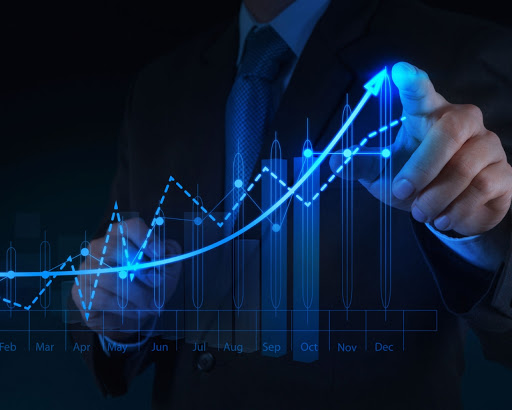

The term bankruptcy is expressed as the inability of a company to pay its debts to its creditors. The bankruptcy of a company and even the possibility of going bankrupt is important for the company's investors and society. Therefore, bankruptcy prediction should be made before the bankruptcy of a company and necessary and appropriate models should be built. In this part of the model, we created machine learning algorithms that can predict whether companies will go bankrupt. In this way, it will be possible to predict the bankruptcy of companies with their financial statements and financial ratios.


**INTRODUCTION**

There are more than 6800 companies in the data used in the bankruptcy prediction model. The bankruptcy cases of these companies in the data are shown as 1 (bankrupted) and 0 (failed to go bankrupt) and it is tried to predict whether they will go bankrupt with 95 financial ratios. 

* **95 features (X1-X95)**

Our goal is to use these features to have clearer information about the future and legitimacy of the companies.

P.s: If you like this notebook don't forget to ****UPVOTE****!

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
## Importing libraries

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, accuracy_score, recall_score, classification_report, f1_score, average_precision_score, precision_recall_fscore_support, roc_auc_score)
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 

import xgboost as XGB
import lightgbm as lgb

from imblearn.over_sampling import SMOTE

import warnings

#Ignore warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#Import data set
data = pd.read_csv('../input/company-bankruptcy-prediction/data.csv')

# **Data Description**

In [ ]:
data.head(20)

In [ ]:
#Shape of the data set
data.shape

In [ ]:
#Now that we have an idea of our data, we need to obtain more information possible on them. The first thing that we want to understand is the nature of our data, namely if the data are numerical or categorical and if we have missing information among them. It is possible to check both these points using the .info() pandas method.
data.info()

In [ ]:
# Computing the descriptive statistics of our numerical features (Statistical summary of our data)
data.describe()

In [ ]:
# Checking any NaN value presence
data.isna().sum().max()

In [ ]:
# Checking for duplicates
data.duplicated().sum()

In [ ]:
print(data['Bankrupt?'].value_counts())
print('_'* 30)
print('Companies that went bankrupt: ', round(data['Bankrupt?'].value_counts()[0]/len(data) * 100,1), '% of whole data set')
print('Companies that did not go bankrupt: ', round(data['Bankrupt?'].value_counts()[1]/len(data) * 100,1), '% of whole data set')

First of all, the distribution of the data for 6819 companies in the data is shown in this figure. As can be seen from the figure, there is a serious imbalance between classes.

In [ ]:
# Checking labels distributions

sns.set_theme(context = 'talk', style='darkgrid', palette='deep', font='sans-serif', font_scale = 0.8, rc={"grid.linewidth": 4})

plt.figure(figsize = (16,9))
sns.countplot(data['Bankrupt?'])
plt.title('Class Distributions \n (0: Failed to go bankrupt || 1: Went bankrupt)', fontsize=16)
plt.show()

# **Data Preprocessing and Train-Test Data Split**

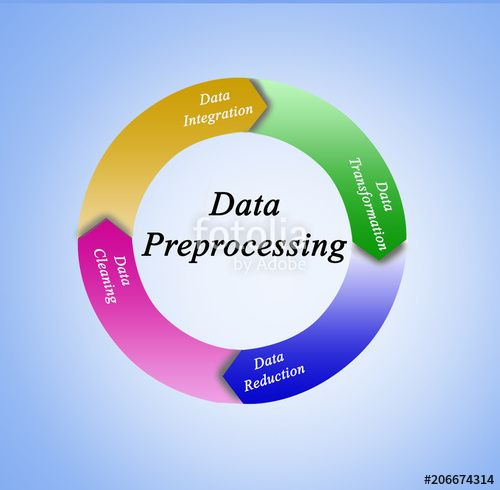

Data pre-processing, which is essentially a technique used in data mining, is a very frequently applied method that should be adopted before the development of machine learning models. Often real-world data is inconsistent, incomplete, and contains some errors, so they are unlikely to be directly analysed. Therefore, the raw data is transformed by pre-processing and put into a useful and an effective format before analysis. Data pre-processing, in its simplest form, includes the steps of cleaning the data (management of incomplete and noisy data), transforming the data (normalization, etc.) and reducing the data (methods such as dimension reduction, etc.). In machine learning processes, data pre-processing is simply done with the following steps:

1. Installing open-source libraries required for data manipulation and analysis, especially Pandas and NumPy
1. Uploading the dataset in the appropriate format
1. Observing the features such as missing data and data type in the data set and eliminating this problem if they are problematic
1. Splitting the data as train and test data in order to apply machine learning algorithms

In order to detect machine learning model behaviours, it is important to divide the data into two as train and test data because machine learning methods are primarily trained through updating various parameters with train data. After the train phase, the machine learning model is tested with a different data set (test da-ta). Thus, how the established model responds to new data (observations) is measured. There are various opinions about how much of the total data should be allocated to train and how much to test data. Although it is necessary to keep the train data as large as possible for very large data, the general opinion is to separate the train and test data with a rate of 80-20%.


In [ ]:
#Cardinality check
{column: len(data[column].unique()) for column in data.columns}

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop single-value column
    df = df.drop(' Net Income Flag', axis=1)

    #We will remove the column Net Income Flag since it has only single value

    # Split df into X and y
    y = df['Bankrupt?']
    X = df.drop('Bankrupt?', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify = y)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [ ]:
#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

In [ ]:
 y_test.value_counts() / len(y_test)

# **Initial Models**

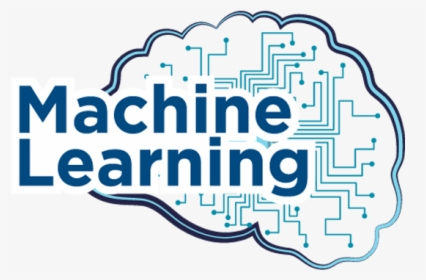

For this prediction, 12 different machine learning algorithms have been used in this case study. The algorithms used are as follows:

**1.	Logistic regression:** It is a machine learning classification method and tries to predict the categorical dependent variable coded as binary (1 – yes, successful etc., 0 – no, unsuccessful etc.).

**2.K-Nearest Neighbors:** It is one of the most commonly used supervised machine learning algorithms. It is mostly used in solving classification problems and is based on the nearest neighbour principle.

**3.	Decision Trees:** It is a tree-based learning algorithm and one of the most used supervised learning algorithms. It has a pre-defined target variable and has a structure used to divide a dataset containing many observations into smaller sets within the framework of various rules.

**4.	Support Vector Machine (Linear Kernel):** It is one of the supervised learning methods generally used in classification problems. SVMs with a linear kernel operate using a linear line separating the two classes.

**5.	Support Vector Machine (Non-Linear Kernel):** It is generally preferred when the data set is not very large. Compared to linear core SVM, it uses non-linear classification method with gamma hyperparameter.

**6.	Artificial Neural Networks:** It can offer a single-layer or multi-layer learning method according to the number of layers. It consists of input, aggregation function, activation function, and outputs.

**7.	Random Forest:** It is a popular machine learning model that can be applied to both regression and classification problems without the need for hyperparameter estimation.

**8.	Gradient Boosting:** It is a method of transforming weak learners into strong learners. First, it creates a starting leaf and then creates new trees by taking into account the errors that occur. This process is continued until a better result cannot be obtained.

**9.	XgBoost Classifier:** It is the optimized and higher performance version of the gradient boosting algorithm in various ways. Possibly overfitting in gradient boosting is avoided by this algorithm.

**10.	AdaBoost Classifier:** It is an iterative ensemble method. It combines very low-performing classifiers to form a powerful classifier.

**11.	Catboost Classifier:** Another classification algorithm based on gradient boosting. Its learning speed is higher than other classifiers and it can work with both numerical, categorical and text data.

**12.	LightGBM Classifier:** It is a histogram-based method that reduces memory usage and speeds up the train of the model.


In [ ]:
original_models = {
    "Logistic Regression": LogisticRegression(solver = "liblinear", l1_ratio = 0.5),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean'),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(C = 0.5),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(loss = "exponential"),
    "XgBoost Classifier": XGB.XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators = 75, learning_rate = 0.3),
    "CatBoost Classifier": CatBoostClassifier(verbose = False),
    "LightGBM": LGBMClassifier()
}

for name, model in original_models.items():
  model.fit(X_train, y_train)
  print(name + ' trained.')

In [ ]:
original_results = []

for name, model in original_models.items():
  result = model.score(X_test, y_test)
  original_results.append(result)

  print("""
  __________________________"""+name+"""__________________________
  """)

  model = original_models[name]
  y_test_pred = model.predict(X_test)
  arg_test = {'y_true':y_test, 'y_pred':y_test_pred}
  print(confusion_matrix(**arg_test))
  print(classification_report(**arg_test))

  print(name + ': {:.5f}%'.format(result * 100))

**Confusion Matrix**

Confusion matrix, which is one of the easiest metrics to measure the accuracy of the model, includes its actual and predicted dimensions. The data, which is actually 1 and estimated as 1 by the model, and is actually 0 and estimated as 0 by the model, shows the number of correct predictions of the model.

In [ ]:
# Plotting confusion matrix for each classifier

a = 3  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(30, 18))

for name, model in original_models.items():
    original_results_smote = model.score(X_test, y_test)
    model = original_models[name]
    y_test_pred_smote = model.predict(X_test)
    arg_test = {'y_true':y_test, 'y_pred':y_test_pred_smote}

    conf_mx0 = confusion_matrix(y_test, y_test_pred_smote)

    heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test), index = np.unique(y_test))
    heat_cm0.index.name = 'Actual'
    heat_cm0.columns.name = 'Predicted'

    plt.subplot(a, b, c)
    #plt.title(name)
    fig.subplots_adjust(left=None, bottom=None, right= None, top=None, wspace=0.4, hspace= 0.4)
    sns.heatmap(heat_cm0, annot=True, fmt='.2f', square=True, annot_kws={"size": 16}, cmap = 'Purples').set_title(name, fontsize = 20)
    c = c + 1

plt.show()

# **Models**

### **Multicollinearity Check**

Multicollinearity means that there is a strong correlation between the independent variables that predict the dependent variable in a regression model. In such a case, it cannot be determined how much effect the independent variables have on the dependent variables individually. Multicollinearity is determined by the 'Variance Inflation Factor (VIF)' and this ratio comes from the correlation between independent variables. Generally, a VIF score above 5 indicates the presence of multicollinearity. In this case, it is suggested as a solution to remove one of the variables that is related to each other from the model. Due to the use of many features in machine learning methods, there may be some overlapping features. Features that overlap with this analysis should be identified and excluded from the analysis.

In [ ]:
correlation_matrix = data.corr()
correlation_matrix.style.background_gradient(sns.light_palette('red', as_cmap=True))

In [ ]:
correlation_matrix = correlation_matrix.iloc[1:,1:]

In [ ]:
drop_correlated_fea = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if(correlation_matrix.iloc[i,j] >= 0.894 or correlation_matrix.iloc[i,j] <= -0.894):
            if correlation_matrix.columns[j] not in drop_correlated_fea:
                drop_correlated_fea.append(correlation_matrix.columns[j])  

In [ ]:
len(drop_correlated_fea)

In [ ]:
data = data.drop(drop_correlated_fea, axis = 1)

In [ ]:
data

### **Oversampling with SMOTE (Original Test Data)**

Unbalanced dataset is a problem that is frequently seen in classification problems and occurs when the class distributions are quite far from each other. This problem arises because the majority class dominates the minority class in machine learning algorithms. Owing to this, algorithms often predict the entire data set very poorly for the minority class, showing proximity to the majority class. Even though there are different metric selection and resampling methods to solve such problems, the SMOTE sampling method is the easiest and most useful method to apply.

SMOTE oversampling technique starts from the samples of the minority class and generates synthetic new observations in the feature space randomly by interpolation method. Thus, it balances the majority class with the number of observations. However, it does not interfere with the model other than increasing the number of samples and does not provide extra information to the model. According to some sources, the point to be considered while applying SMOTE is that the method should be applied only to the train data set and the original test data should be used while testing the data. Nevertheless, in some models, after all the data is balanced with the SMOTE method, the split of train and test data and the application of algorithms in this way also stand out in practice.


In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop single-value column
    df = df.drop(' Net Income Flag', axis=1)

    #We will remove the column Net Income Flag since it has only single value

    # Split df into X and y
    y = df['Bankrupt?']
    X = df.drop('Bankrupt?', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify = y)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [ ]:
def preprocess_inputs(df_):
    df_ = df_.copy()
    
    # Drop single-value column
    df_ = df_.drop(' Net Income Flag', axis=1)

    #We will remove the column Net Income Flag since it has only single value

    # Split df into X and y
    y_ = df_['Bankrupt?']
    X_ = df_.drop('Bankrupt?', axis=1)

    #Initializing SMOTE

    sm = SMOTE(random_state = 42)
    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    sm = SMOTE(random_state = 42)
    X_test_oversampled, y_test_oversampled = sm.fit_resample(X_train_smote, y_train_smote)
    X_train_smote = pd.DataFrame(X_test_oversampled, columns=X_.columns)

    return X_train_smote, y_train_smote

In [ ]:
X_train_smote, y_train_smote = preprocess_inputs(data)

In [ ]:
print('X_train_smote shape is ' , X_train_smote.shape) # Train data after SMOTE
print('y_train_smote shape is ' , y_train_smote.shape) # Train data after SMOTE
print('X_test_smote shape is ' , X_test.shape) # Original test data
print('y_test_smote shape is ' , y_test.shape) # Original test data

In [ ]:
sns.set_theme(context = 'talk', style='darkgrid', palette='deep', font='sans-serif', font_scale = 0.8, rc={"grid.linewidth": 4})

plt.figure(figsize = (16,9))
sns.countplot(y_train_smote)
plt.title('Class Distributions \n (0: Failed to go bankrupt || 1: Went bankrupt)', fontsize=16)
plt.show()

In [ ]:
original_models_smote_ot = {
    "Logistic Regression": LogisticRegression(solver = "liblinear", l1_ratio = 0.5),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean'),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(C = 0.5),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(loss = "exponential"),
    "XgBoost Classifier": XGB.XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators = 75, learning_rate = 0.3),
    "CatBoost Classifier": CatBoostClassifier(verbose = False),
    "LightGBM": LGBMClassifier()
}

for name, model in original_models_smote_ot.items():
  model.fit(X_train_smote, y_train_smote)
  print(name + ' trained.')

In [ ]:
original_results_smote_ot = []

for name, model in original_models_smote_ot.items():
  result_smote = model.score(X_test, y_test)
  original_results_smote_ot.append(result_smote)

  print("""
  __________________________"""+name+"""__________________________
  """)

  model = original_models_smote_ot[name]
  y_test_pred_smote = model.predict(X_test)
  arg_test = {'y_true':y_test, 'y_pred':y_test_pred_smote}
  print(confusion_matrix(**arg_test))
  print(classification_report(**arg_test))

  print(name + ': {:.5f}%'.format(result_smote * 100))

**ROC Curve**

Then, all data have been trained with 12 models using the train data. The point to note in this regard is that SMOTE is applied only to the train data in the initial data. That is, the test data is kept as the original data at this stage. The sample has been expanded with SMOTE and then the data has been trained with a larger sample, but the models have been tested with the original test data. Since the models were trained with more data, the test data has been predicted to be better than the initial model. Figure below gives the ROC curve of the models. As can be seen from the ROC curve and confusion matrices, while logistic regression, SVM methods (especially RBF kernel) and AdaBoost classifier give relatively good results, the results of other models are only mediocre.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25,12)

for m in original_models_smote_ot:
    y_pred = original_models_smote_ot[m].predict(X_test)
    fpr, tpr, thresholds_nb = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    precision_nb, recall_nb, th_nb = precision_recall_curve(y_test, y_pred,pos_label=1)
    plt.plot(fpr, tpr, label= m + ': {:.5f}'.format(roc_auc_score(y_test, y_pred)))
plt.plot([0, 1], [0, 1], 'r--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=14)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=14)
plt.title('ROC Curve', fontweight='bold', fontsize=18)
plt.legend(loc='best')
plt.show()


In [ ]:
# Plotting confusion matrix for each classifier

a = 3  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(30, 18))

for name, model in original_models_smote_ot.items():
    original_results_smote_ot = model.score(X_test, y_test)
    model = original_models_smote_ot[name]
    y_test_pred_smote = model.predict(X_test)
    arg_test = {'y_true':y_test, 'y_pred':y_test_pred_smote}

    conf_mx0 = confusion_matrix(y_test, y_test_pred_smote)

    heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test), index = np.unique(y_test))
    heat_cm0.index.name = 'Actual'
    heat_cm0.columns.name = 'Predicted'

    plt.subplot(a, b, c)
    #plt.title(name)
    fig.subplots_adjust(left=None, bottom=None, right= None, top=None, wspace=0.4, hspace= 0.4)
    sns.heatmap(heat_cm0, annot=True, fmt='.2f', square=True, annot_kws={"size": 16}, cmap = 'Purples').set_title(name, fontsize = 20)
    c = c + 1

plt.show()

### **Oversampling with SMOTE (SMOTE Test Data)**

In this analysis, SMOTE technique has been applied to the raw data. Afterwards, train and test data have been created. Thus, the trained models were validated with the test data, which has a more balanced class distribution. Nevertheless, due to the loss of originality of the test data, there was a problem of overfitting in the models. 

In [ ]:
def preprocess_inputs(df_):
    df_ = df_.copy()
    
    # Drop single-value column
    df_ = df_.drop(' Net Income Flag', axis=1)

    #We will remove the column Net Income Flag since it has only single value

    # Split df into X and y
    y_ = df_['Bankrupt?']
    X_ = df_.drop('Bankrupt?', axis=1)

    #Initializing SMOTE

    sm = SMOTE(random_state = 42)
    X_smote, y_smote = sm.fit_resample(X_, y_)

    sm = SMOTE(random_state = 42)
    X_test_oversampled, y_test_oversampled = sm.fit_resample(X_smote, y_smote)
    X_smote = pd.DataFrame(X_test_oversampled, columns=X_.columns)
    
    # Train-test split
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, train_size = 0.8, test_size = 0.2, random_state=1, shuffle=True, stratify = y_smote)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train_smote)
    X_train_smote = pd.DataFrame(scaler.transform(X_train_smote), index=X_train_smote.index, columns=X_train_smote.columns)
    X_test_smote = pd.DataFrame(scaler.transform(X_test_smote), index=X_test_smote.index, columns=X_test_smote.columns)
    
    return X_train_smote, X_test_smote, y_train_smote, y_test_smote, y_smote

In [ ]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote, y_smote = preprocess_inputs(data)

In [ ]:
print('X_train_smote shape is ' , X_train_smote.shape) # Train data after SMOTE
print('y_train_smote shape is ' , y_train_smote.shape) # Train data after SMOTE
print('X_test_smote shape is ' , X_test_smote.shape) # Test data after SMOTE
print('y_test_smote shape is ' , y_test_smote.shape) # Test data after SMOTE

SMOTE technique has been applied directly to the raw data (before train-test data split). The data distribution obtained is as shown in figure.

In [ ]:
sns.set_theme(context = 'talk', style='darkgrid', palette='deep', font='sans-serif', font_scale = 0.8, rc={"grid.linewidth": 4})

plt.figure(figsize = (16,9))
sns.countplot(y_smote)
plt.title('Class Distributions \n (0: Failed to go bankrupt || 1: Went bankrupt)', fontsize=16)
plt.show()

In [ ]:
original_models_smote_st = {
    "Logistic Regression": LogisticRegression(solver = "liblinear", l1_ratio = 0.5),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean'),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(C = 0.5),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(loss = "exponential"),
    "XgBoost Classifier": XGB.XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators = 75, learning_rate = 0.3),
    "CatBoost Classifier": CatBoostClassifier(verbose = False),
    "LightGBM": LGBMClassifier()
}

for name, model in original_models_smote_st.items():
  model.fit(X_train_smote, y_train_smote)
  print(name + ' trained.')

In [ ]:
original_results_smote_st = []

for name, model in original_models_smote_st.items():
  result_smote = model.score(X_test_smote, y_test_smote)
  original_results_smote_st.append(result_smote)

  print("""
  __________________________"""+name+"""__________________________
  """)

  model = original_models_smote_st[name]
  y_test_pred_smote = model.predict(X_test_smote)
  arg_test = {'y_true':y_test_smote, 'y_pred':y_test_pred_smote}
  print(confusion_matrix(**arg_test))
  print(classification_report(**arg_test))

  print(name + ': {:.5f}%'.format(result_smote * 100))

**ROC Curve**

Figure shows the ROC curve of the model. As can be seen from both performance metrics, many models predicted classes with around 95% success. Especially the success of models such as Neural network, Random Forest, CatBoost and LightGBM is very high.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25,12)

for m in original_models_smote_st:
    y_pred = original_models_smote_st[m].predict(X_test_smote)
    fpr, tpr, thresholds_nb = roc_curve(y_test_smote, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    precision_nb, recall_nb, th_nb = precision_recall_curve(y_test_smote, y_pred,pos_label=1)
    plt.plot(fpr, tpr, label= m + ': {:.5f}'.format(roc_auc_score(y_test_smote, y_pred)))
plt.plot([0, 1], [0, 1], 'r--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=14)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=14)
plt.title('ROC Curve', fontweight='bold', fontsize=18)
plt.legend(loc='best')
plt.show()

In [ ]:
# Plotting confusion matrix for each classifier

a = 3  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(30, 18))

for name, model in original_models_smote_st.items():
    original_results_smote_st = model.score(X_test_smote, y_test_smote)
    model = original_models_smote_st[name]
    y_test_pred_smote = model.predict(X_test_smote)
    arg_test = {'y_true':y_test_smote, 'y_pred':y_test_pred_smote}

    conf_mx0 = confusion_matrix(y_test_smote, y_test_pred_smote)

    heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test_smote), index = np.unique(y_test_smote))
    heat_cm0.index.name = 'Actual'
    heat_cm0.columns.name = 'Predicted'

    plt.subplot(a, b, c)
    #plt.title(name)
    fig.subplots_adjust(left=None, bottom=None, right= None, top=None, wspace=0.4, hspace= 0.4)
    sns.heatmap(heat_cm0, annot=True, fmt='.2f', square=True, annot_kws={"size": 16}, cmap = 'Purples').set_title(name, fontsize = 20)
    c = c + 1

plt.show()

### **Dimensionality Reduction (PCA)**

Dimension reduction is essentially reducing the number of features in the data. Since the presence of many features can make the model difficult to understand and manage, dimension reduction can be used to make the model less complex. In addition, it can be said that the use of too many features shows poor performance in machine learning algorithms, and models run longer by consuming more memory. Although no "best" method can be directly suggested for dimension reduction, this can be achieved with various techniques such as missing value ratio in features, low-high correlation filter, random forest algorithm, factor analysis, principal component analysis. In short, the model is simplified with dimension reduction, and it is ensured that the model is created more easily with basic variables.

In [ ]:
n_components = 74

pca = PCA(n_components)
pca.fit(X_train_smote)

X_train_reduced = pd.DataFrame(pca.transform(X_train_smote), index = X_train_smote.index, columns = ['PC' + str(i) for i in range(1, n_components + 1)])
X_test_reduced = pd.DataFrame(pca.transform(X_test_smote), index = X_test_smote.index, columns = ['PC' + str(i) for i in range(1, n_components + 1)])

In [ ]:
X_train_reduced.describe()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
fig = px.bar(
    x = ['PC' + str(i) for i in range(1, n_components + 1)],
    y = pca.explained_variance_ratio_,
    labels = {'x': "Principal Component", 'y': 'Variance Ratio'},
    color = pca.explained_variance_ratio_,
    color_continuous_scale = [(0,'darkblue'), (1, 'lightblue')],
    title = 'Proportion of variance in Principal Components'
        
)
         
fig.show()

As a result of the analysis depicted in Figure above, the contribution of the variables to the model has been shown and a "reduced model" has been established with 7 attributes according to the graph. Since the marginal contribution of the features after the 7 features to the model has decreased noticeably, it is enough to select 7 features.

In [ ]:
n_components = 7

pca = PCA(n_components)
pca.fit(X_train_smote)

X_train_reduced = pd.DataFrame(pca.transform(X_train_smote), index = X_train_smote.index, columns = ['PC' + str(i) for i in range(1, n_components + 1)])
X_test_reduced = pd.DataFrame(pca.transform(X_test_smote), index = X_test_smote.index, columns = ['PC' + str(i) for i in range(1, n_components + 1)])

In [ ]:
pca.explained_variance_ratio_

### **Reduced Model**

Afterwards, dimension reduction has been applied in order to express the model with fewer attributes. In this way, it is aimed to establish a decent enough model with fewer variables.

In [ ]:
reduced_models_smote = {
    "Logistic Regression": LogisticRegression(solver = "liblinear", l1_ratio = 0.5),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean'),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(C = 0.5),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(loss = "exponential"),
    "XgBoost Classifier": XGB.XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators = 75, learning_rate = 0.3),
    "CatBoost Classifier": CatBoostClassifier(verbose = False),
    "LightGBM": LGBMClassifier()
}

for name, model in reduced_models_smote.items():
  model.fit(X_train_reduced, y_train_smote)
  print(name + ' trained.')

In [ ]:
reduced_results_smote = []

for name, model in reduced_models_smote.items():
  reduced_result_smote = model.score(X_test_reduced, y_test_smote)
  reduced_results_smote.append(reduced_result_smote)

  print("""
  __________________________"""+name+"""__________________________
  """)

  model = reduced_models_smote[name]
  y_test_pred_smote = model.predict(X_test_reduced)
  arg_test = {'y_true':y_test_smote, 'y_pred':y_test_pred_smote}
  print(confusion_matrix(**arg_test))
  print(classification_report(**arg_test))

  print(name + ': {:.5f}%'.format(reduced_result_smote * 100))

After the dimension reduction was performed, the new data with 7 variables was rerun with the SMOTE model (in which the test data was also SMOTE). ROC curve and confusion matrices gave relatively poor results compared to the original model, but despite the fact that the model could be expressed with only 7 variables instead of 74, no tremendous performance degradation was observed. Figures below shows the ROC curves and confusion matrices of the “reduced model”. 

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)

fig, ax = plt.subplots()
fig.set_size_inches(25,12)

for m in reduced_models_smote:
    y_pred = reduced_models_smote[m].predict(X_test_reduced)
    fpr, tpr, thresholds_nb = roc_curve(y_test_smote, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    precision_nb, recall_nb, th_nb = precision_recall_curve(y_test_smote, y_pred,pos_label=1)
    plt.plot(fpr, tpr, label= m + ': {:.5f}'.format(roc_auc_score(y_test_smote, y_pred)))
plt.plot([0, 1], [0, 1], 'b--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=14)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=14)
plt.title('ROC Curve', fontweight='bold', fontsize=18)
plt.legend(loc='best')
plt.show()


In [ ]:
# Plotting confusion matrix for each classifier

a = 3  
b = 4  
c = 1

fig = plt.figure(figsize=(30, 18))

for name, model in reduced_models_smote.items():
    reduced_result_smote = model.score(X_test_reduced, y_test_smote)
    model = reduced_models_smote[name]
    y_test_pred_smote = model.predict(X_test_reduced)
    arg_test = {'y_true':y_test_smote, 'y_pred':y_test_pred_smote}

    conf_mx0 = confusion_matrix(y_test_smote, y_test_pred_smote)

    heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test_smote), index = np.unique(y_test_smote))
    heat_cm0.index.name = 'Actual'
    heat_cm0.columns.name = 'Predicted'

    plt.subplot(a, b, c)
    #plt.title(name)
    fig.subplots_adjust(left=None, bottom=None, right= None, top=None, wspace=0.4, hspace= 0.4)
    sns.heatmap(heat_cm0, annot=True, fmt='.2f', square=True, annot_kws={"size": 16}, cmap = 'Purples').set_title(name, fontsize = 20)
    c = c + 1

plt.show()

### **Change in Performance After PCA**

Figure shows how the performance of the 12 models changed after dimension reduction. In spite of the decrease of roughly 10% in some models, it can be said that it is quite satisfactory to establish models with only 7 features.

In [ ]:
fig_dim_red = px.bar(
    x=np.subtract(reduced_results_smote, original_results_smote_st),
    y=original_models_smote_st.keys(),
    orientation='h',
    labels={'x': "<b>Change in Performance<b>", 'y': "<b>Model<b>"},
    color=np.subtract(reduced_results_smote, original_results_smote_st),
    color_continuous_scale=[(0, 'yellow'), (1, 'red')],
    title="<b>Change in Model Performance After Dimensionality Reduction<b>"
)

fig_dim_red.show()